In [241]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
import json
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import scipy.io.wavfile as wav
import pickle

In [242]:
data_dir = r'C:\Users\TOSHIBA\OneDrive\Desktop\Skripsi\Dataset'
json_path = 'FDiff.json'
fixed_sample = 22050 * 3

In [243]:
def dataTrain():

    data = {}

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_dir)):

        if dirpath is not data_dir:

            label = os.path.basename(dirpath)
            print("\nProcessing: '{}'".format(label))
            data[label] = []
            for f in filenames:
                file_path = os.path.join(dirpath, f)

                signal, sample_rate = librosa.load(file_path)

                if len(signal) >= fixed_sample:
                    signal = signal[:fixed_sample]

                MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
                data[label].append(MFCCs.T.tolist())

                    
    json_data = json.dumps(data, indent=2)
    
    with open(json_path, "w") as json_file:
        json_file.write(json_data)

In [244]:
dataTrain()


Processing: 'ambulance'

Processing: 'firetruck'

Processing: 'police'


In [245]:
def train_HMM(dataset):
    Models = {}
    for label in dataset.keys():
        model = hmm.GaussianHMM(n_components=3)
        trainData = dataset[label]
        trData = np.vstack(trainData)
        model.fit(trData)
        Models[label] = model
    return Models

In [246]:
with open(json_path, "r") as fp:
    data = json.load(fp)

train_data = {}
test_data = {}
for label, features in data.items():
    train_features, test_features = train_test_split(features, test_size=0.2, random_state=42)
    train_data[label] = train_features
    test_data[label] = test_features

In [247]:
hmmModels = train_HMM(train_data)

In [248]:
print(hmmModels)

{'ambulance': GaussianHMM(n_components=3), 'firetruck': GaussianHMM(n_components=3), 'police': GaussianHMM(n_components=3)}


In [249]:
acc_count = 0
all_data_count = 0

label_true = []
label_pred = []

for label in test_data.keys():
    feature = test_data[label]
    for index in range(len(feature)):
        # print(index)
        all_data_count+=1
        scoreList = {}
        for model_label in hmmModels.keys():
            model = hmmModels[model_label]
            score = model.score(feature[index])
            scoreList[model_label] = score
        predict = max(scoreList, key=scoreList.get)
        if predict == label:
            acc_count+=1
        label_true.append(label)
        label_pred.append(predict) 

print(acc_count)
print(all_data_count)
accuracy = round(((acc_count/all_data_count)*100.0),3)

print(accuracy)
print(label_true)
print(label_pred)

216
251
86.056
['ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulance', 'ambulanc

In [250]:
with open('HMModel.pkl', 'wb') as f:
    pickle.dump(hmmModels, f)

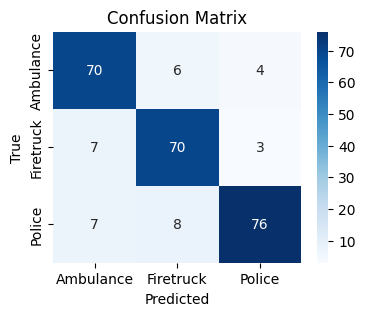

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns

label_names = ['Ambulance', 'Firetruck', 'Police']
cm = confusion_matrix(label_true, label_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [252]:
print(classification_report(label_true, label_pred))

print(accuracy_score(label_true, label_pred))

              precision    recall  f1-score   support

   ambulance       0.83      0.88      0.85        80
   firetruck       0.83      0.88      0.85        80
      police       0.92      0.84      0.87        91

    accuracy                           0.86       251
   macro avg       0.86      0.86      0.86       251
weighted avg       0.86      0.86      0.86       251

0.8605577689243028
